This step is to analyze the pair which we have selected in the previous step.

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# change default plot parameters
plt.rcParams['figure.figsize'] = [6, 4]
plt.rcParams['figure.dpi'] = 100

### SETUP & READ FILE

#### Setup

In [35]:
# "0" to use all available dates, "1" for custom dates
custom_date = 0

# "1" to add a regression coefficient α for Y*(t) = β * x*(t) + α
enable_regression_coef = 0

# number of samples for linear regression
# "0" to use all datapoints
N = 90

In [36]:
if custom_date:
    df = pd.read_pickle("saved_custom.pkl")
else:
    df = pd.read_pickle("saved.pkl")  

df.head()

,close_x,volume_x,ticker_x,close_y,volume_y,ticker_y
datetime,,,,,,
2021-11-01 04:00:00+00:00,26.290001,3730100,CNP,20.010000,2756500,VST
2021-11-02 04:00:00+00:00,26.190001,5620500,CNP,19.870001,4006000,VST
2021-11-03 04:00:00+00:00,26.290001,3350900,CNP,19.680000,2460100,VST
2021-11-04 04:00:00+00:00,26.500000,3364800,CNP,19.209999,6093500,VST
2021-11-05 04:00:00+00:00,26.670000,3179000,CNP,20.500000,9136100,VST


### CORRELATION & VISUAL OBSERVATION

In [37]:
df_corr = df[['close_x','close_y']]
df_corr = df_corr.rename(columns={"close_x": df.ticker_x[0], "close_y": df.ticker_y[0]})
print('Corr. Matrix:')
print(df_corr.corr(method='pearson'))

Corr. Matrix:
          CNP       VST
CNP  1.000000  0.885624
VST  0.885624  1.000000


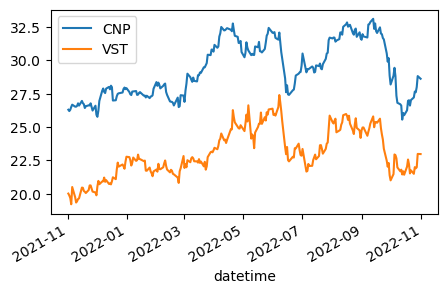

In [38]:
# change current plot parameters. use it before defining the plot
_ = plt.figure(figsize=(5,3))

df.close_x.plot(label=df.ticker_x[0])
df.close_y.plot(label=df.ticker_y[0])
plt.legend()

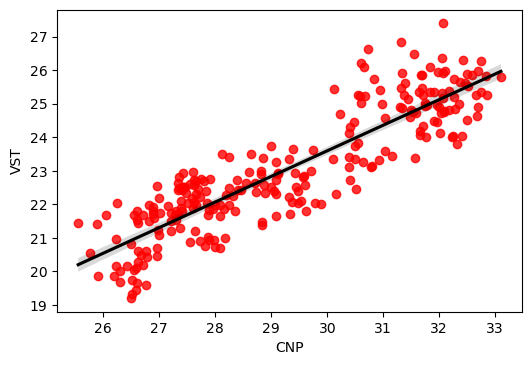

In [39]:
import seaborn as sb

# seaborn is nice to visualize a linear fit
#sb.scatterplot("close_x", "close_y", s=30, edgecolor="none", data=df)
scplot = sb.regplot(x="close_x", y="close_y", data=df, scatter_kws={"color": "red"}, line_kws={"color": "black"});
scplot.set(xlabel=df.ticker_x[0], ylabel=df.ticker_y[0])
 
# or you can enable to use pandas, but you should dray the regression line separately
# plt.scatter(df.close_y,df.close_x)
# plt.xlabel(df.ticker_x[0])
# plt.ylabel(df.ticker_y[0])

plt.show()

### ORTHOGONAL SPREAD ANALYSIS

In [40]:
import statsmodels.api as sm

#  implement Ordinary Least Squares(OLS) method of linear regression
#  Y*(t) = β * x*(t) + α

if N>0: # for the recent N rows
    Y = df.close_y.iloc[-N:]
    X = df.close_x.iloc[-N:]
else:
    Y = df.close_y
    X = df.close_x

# ENABLE if you want to add a regression coefficient α
if enable_regression_coef:
    X = sm.add_constant(X)

model = sm.OLS(Y, X) # for the last N rows
model = model.fit()

# get the model coef
if len(model.params) == 1:
    print("β * x(t)")
    print(f"COEF β: {model.params[0]}")
    hedge = round(float(model.params[0]),2)
    print(f"\u001b[43;1mHEDGE: {hedge}\u001b[0m")
    alfa = 0
else:
# get the model coef with regression coefficient α
    print("β * x(t) + α")
    print(f"COEF β: {model.params[1]}")
    hedge = round(float(model.params[1]),2)
    print(f"COEF α: {model.params[0]}")
    alfa = round(float(model.params[0]),2)
    print(f"\u001b[43;1mHEDGE: {hedge}\u001b[0m")
    
if hedge<0:
    print("\u001b[41;1mAvoid pairs with negative β\u001b[0m")
     
# print pair equation
print(f"EQUATION: {df.ticker_y[0]}={hedge}*{df.ticker_x[0]}{'+' + str(round(alfa,1)) if alfa>0 else ''}")
# enable to see the model summary
# model.summary()

β * x(t)
COEF β: 0.7829309411807653
HEDGE: 0.78
EQUATION: VST=0.78*CNP


### ORTHOGONAL RESIDUALS

mean : 0.2091174274020717 | std dev : 0.8416336092378484
min : -1.4600009155273455 | max : 2.650601196289063


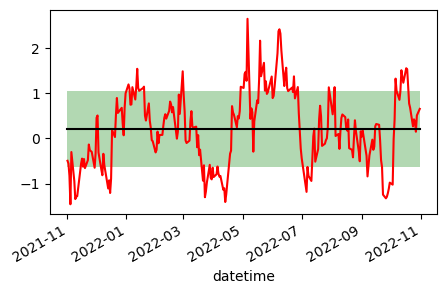

In [41]:
# spread y(t) - β * x(t) - α
spread = df['spread'] = df.close_y - hedge * df.close_x - alfa
df['mean_spread'] = spread.mean()

# lower and upper bounds
std_spread = spread.std()
df['std_upper'] = df['mean_spread'] + std_spread
df['std_lower'] = df['mean_spread'] - std_spread

print(f"mean : {spread.mean()} | std dev : {std_spread}")
print(f"min : {spread.min()} | max : {spread.max()}")


# plot
# change current plot parameters. use it before defining the plot
_ = plt.figure(figsize=(5,3))

# df[['spread','mean_spread','std_lower','std_upper']].plot()
df.spread.plot(label='spread', color='red')
df.mean_spread.plot(label='mean', color='black')
plt.fill_between(df.index, df.std_lower, df.std_upper, facecolor='green', alpha=0.3);


### UNIT ROOT TEST

#### Augmented Dickey-Fuller Unit Root Test

In [42]:
# The Augmented Dickey-Fuller test can be used to test for a unit root
# The ADF test expands the Dickey-Fuller test equation to include high order regressive process in the model.

# Null Hypothesis: No cointegration
# Decision Rule:Reject the null hypothesis if the  test statistic is less than the critical value

# The presence of a unit root is one cause for non-stationarity
# An ideal time series has stationarity.
# That means that a shift in time doesn’t cause a change in the shape of the distribution. 
# Data points are often non-stationary or have means, variances, and covariances that change over time.
# Non-stationary behaviors can be trends, cycles, random walks, or combinations of the three.
# Non-stationary data, as a rule, are unpredictable and cannot be modeled or forecasted.


from statsmodels.tsa.stattools import adfuller

# By default, lag value is 12*(nobs/100)^{1/4}, where nobs is the number of observations in the series.
# But, optionally you can specify either the maximum number of lags with maxlags parameter
# or let the algorithm compute the optimal number iteratively. This can be done by setting the autolag='AIC'
#adf = adfuller(df.spread, maxlag = 1)
adf = adfuller(df.spread, autolag='AIC')

# show test statistic
print(f"test stat. : {adf[0]}")
stat = adf[0]

# show pvalue
# The p-value only tells you how likely the data you have observed is to have occurred under the null hypothesis.
# If the p-value is below your threshold of significance (typically p < 0.05), then you can reject the null hypothesis, but this does not necessarily mean that your alternative hypothesis is true.
print(f"p-value: {adf[1]}")

# show critical values
print(f"critical values: {adf[4]}")
critical_values = adf[4]

# print pair equation
import sys
green_bg = '\u001b[42;1m'
red_bg = '\u001b[41;1m'
reset_bg = '\u001b[0m' 
print(f"90% CONFIDENCE: {green_bg + 'PASSED' if critical_values['10%']>stat else red_bg + ' FAILED'}{reset_bg}")
print(f"95% CONFIDENCE: {green_bg + 'PASSED (H0 rejected, the time series is stationary)' if critical_values['5%']>stat else red_bg + ' FAILED (residuals seem to contain a unit root, the time series is non-stationary)'}{reset_bg}")
print(f"99% CONFIDENCE: {green_bg + 'PASSED (H0 rejected, the time series is stationary)' if critical_values['1%']>stat else red_bg + ' FAILED (residuals seem to contain a unit root, the time series is non-stationary)'}{reset_bg}")

test stat. : -4.096918425479465
p-value: 0.0009799463998137034
critical values: {'1%': -3.4566744514553016, '5%': -2.8731248767783426, '10%': -2.5729436702592023}
90% CONFIDENCE: PASSED
95% CONFIDENCE: PASSED (H0 rejected, the time series is stationary)
99% CONFIDENCE: PASSED (H0 rejected, the time series is stationary)


#### Phillips-Perron Unit Root Test

In [43]:
# Phillips-Perron unit root test
# https://arch.readthedocs.io/en/latest/unitroot/generated/arch.unitroot.PhillipsPerron.html

#A great advantage of Philips-Perron test is that it is non-parametric,
#i.e. it does not require to select the level of serial correlation as in ADF.
#It rather takes the same estimation scheme as in DF test, but corrects the statistic
#to conduct for autocorrelations and heteroscedasticity (HAC type corrections).

#The main disadvantage of the PP test is that it is based on asymptotic theory.
#Therefore it works well only in large samples that are indeed luxury if not it
# comes for financial time series data. And it also shares
# disadvantages of ADF tests: sensitivity to structural breaks, poor small sample power
# too often resulting in unit root conclusions.


# Parameters
# y{ndarray, Series}: The data to test for a unit root

# lagsint, optional
# The number of lags to use in the Newey-West estimator of the long-run covariance. If omitted or None, the lag length is set automatically to 12 * (nobs/100) ** (1/4)

# trend{“n”, “c”, “ct”}, optional
# The trend component to include in the test

# “n” - No trend components
# “c” - Include a constant (Default)
# “ct” - Include a constant and linear time trend

# test_type{“tau”, “rho”}
# The test to use when computing the test statistic. “tau” is based on the t-stat and “rho” uses a test based on nobs times the re-centered regression coefficien

import arch.unitroot as at
pp = at.PhillipsPerron(df.spread, trend='ct', test_type='rho')
stat = pp.stat
print(f"test stat. : {pp.stat}")
print(f"p-value: {pp.pvalue}")
print(f"critical values: {pp.critical_values}")
critical_values = pp.critical_values


# print pair equation
import sys
green_bg = '\u001b[42;1m'
red_bg = '\u001b[41;1m'
reset_bg = '\u001b[0m' 
print(f"90% CONFIDENCE: {green_bg + 'PASSED' if critical_values['10%']>stat else red_bg + ' FAILED'}{reset_bg}")
print(f"95% CONFIDENCE: {green_bg + 'PASSED (H0 rejected, the time series is stationary)' if critical_values['5%']>stat else red_bg + ' FAILED (residuals seem to contain a unit root, the time series is non-stationary)'}{reset_bg}")
print(f"99% CONFIDENCE: {green_bg + 'PASSED (H0 rejected, the time series is stationary)' if critical_values['1%']>stat else red_bg + ' FAILED (residuals seem to contain a unit root, the time series is non-stationary)'}{reset_bg}")


test stat. : -33.23932302593357
p-value: 0.004148306000452942
critical values: {'1%': -28.44956269586627, '5%': -21.200229467423238, '10%': -17.878007111330238}
90% CONFIDENCE: PASSED
95% CONFIDENCE: PASSED (H0 rejected, the time series is stationary)
99% CONFIDENCE: PASSED (H0 rejected, the time series is stationary)


#### Engle-Granger Two-Step Cointegration Test

In [44]:
# This uses the augmented Engle-Granger two-step cointegration test.
# Constant or trend is included in 1st stage regression, i.e. in cointegrating equation.
# The Null hypothesis is that there is no cointegration, the alternative hypothesis is that
# there is cointegrating relationship. If the pvalue is small, below a critical size, then
#we can reject the hypothesis that there is no cointegrating relationship.

from statsmodels.tsa.stattools import coint
# coint,p,_= coint(df.close_x,df.close_y)
coint = coint(df.close_x,df.close_y)

stat = coint[0]
critical_values = coint[2]

print(f"t-stat. : {stat}")
print(f"p-value: {coint[1]}")
print(f"critical values: {critical_values}")

# print pair equation
import sys
green_bg = '\u001b[42;1m'
red_bg = '\u001b[41;1m'
reset_bg = '\u001b[0m' 
print(f"90% CONFIDENCE: {green_bg + 'PASSED' if critical_values[2]>stat else red_bg + ' FAILED'}{reset_bg}")
print(f"95% CONFIDENCE: {green_bg + 'PASSED (there is cointegrating relationship)' if critical_values[1]>stat else red_bg + ' FAILED (there is no cointegration)'}{reset_bg}")
print(f"99% CONFIDENCE: {green_bg + 'PASSED (there is cointegrating relationship)' if critical_values[0]>stat else red_bg + ' FAILED (there is no cointegration)'}{reset_bg}")


t-stat. : -3.708762037061511
p-value: 0.0178554964790457
critical values: [-3.94060523 -3.36058133 -3.06139039]
90% CONFIDENCE: PASSED
95% CONFIDENCE: PASSED (there is cointegrating relationship)
99% CONFIDENCE:  FAILED (there is no cointegration)
